<a href="https://colab.research.google.com/github/MarcelLopes7/Machine-Learning---Analytics/blob/main/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning & Analytics
## Autor: Marcel Antonio Lopes Pereira

## Introdução

Esse MVP consiste na construção de um modelo de machine learning a partir de um dataset com dados de usuários de uma academia de exercícios físicos (Gym Members Exercise Dataset). Para compreensão do dataset em questão, os respectivos atributos são listados a seguir:

**Idade**: Idade do usuário da academia.

**Gênero**: Gênero do usuário da academia (Masculino ou Feminino).

**Peso (kg)**: Peso do usuário em quilogramas.

**Altura (m)**: Altura do usuário em metros.

**BPM Máx**: Frequência cardíaca máxima (batimentos por minuto) durante as sessões de treino.

**BPM Médio**: Frequência cardíaca média durante as sessões de treino.

**BPM Repouso**: Frequência cardíaca em repouso antes do treino.

**Duração da Sessão (horas)**: Duração de cada sessão de treino em horas.

**Calorias Queimadas**: Total de calorias queimadas durante cada sessão.

**Tipo de Treino**: Tipo de treino realizado (por exemplo, Cardio, Força, Yoga, HIIT).

**Percentual de Gordura**: Percentual de gordura corporal do usuário.

**Consumo de Água (litros)**: Consumo diário de água durante os treinos.

**Frequência de Treino (dias/semana)**: Número de sessões de treino por semana.

**Nível de Experiência**: Nível de experiência, de iniciante (1) a especialista (3).

**IMC**: Índice de Massa Corporal, calculado a partir da altura e do peso.

A partir da descrição dos atributos, é possível identificar várias ideias de problemas para ser solucinados. Foi escolhido um problema que consiste na predição do número de calorias queimadas por um usuário. Como o resultado dessa predição é um valor contínuo, esse é um problema de regressão, sendo então de aprendizado supervisionado. Inicialmente, serão explorados esses dados para entender suas distruibuições e correlações. A partir disso, será descrito o procedimento de tratamento e preparação dos mesmos para construção do modelo. Todo o processo de construção do modelo será detalhado, com suas definições e decisões tomadas.

## Importação das bibliotecas

Com os atributos definidos, o código do programa inicia com a importação das bibliotecas python que serão utilizadas nesse projeto. A seguir, são definidas algumas funções que serão utilizadas ao longo do código.

In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import missingno as ms # para tratamento de missings
import math

## Importação das bibliotecas do scikitlearn para construção do modelo
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer

Essa biblioteca inclui um recurso para tradução de idiomas.

In [2]:
!pip install googletrans==4.0.0-rc1
from googletrans import Translator

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=2c4bab6e7fac539d68c4d09acc3c178893686f7961e2aacc6ff7a64054feb215
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Succ

## Funções utilizadas no programa

São definidas a seguir as funções utilizadas no código do programa para realizar algumas tarefas necessárias no projeto. A primeira delas é a função que realização normalização das colunas do dataset, removendo espaço, quebras de linha e caracteres especiais. Após definida essa função, são definidas funções para realizar a tradução do nome das colunas do inglês para o português.

In [3]:
# Função para normalizar o nome das colunas
# (remover espaços, quebras de linha e caracteres especiais)
def normalizar_coluna(coluna):
    # Remover quebras de linha, espaços extras e
    # caracteres especiais como hifens
    return re.sub(r'[\s\n\-_]+', ' ', coluna).strip().lower()

# Função para renomear as colunas e identificar as
# que não foram traduzidas
def traduzir_colunas(df, colunas_traduzidas):
    colunas_nao_traduzidas = []

    def traduzir_nome_coluna(coluna):
        nome_normalizado = normalizar_coluna(coluna)
        if nome_normalizado in colunas_traduzidas:
            return colunas_traduzidas[nome_normalizado]
        else:
            colunas_nao_traduzidas.append(coluna)  #
            # Adicionar colunas não traduzidas à lista
            return coluna  # Retorna o nome original se não for encontrado

    # Renomear as colunas
    df_traduzido = df.rename(columns=traduzir_nome_coluna)

    if colunas_nao_traduzidas:
        print("Colunas que não foram traduzidas:",
              colunas_nao_traduzidas)
    else:
        print("Todas as colunas foram traduzidas com sucesso.")

    return df_traduzido

Essa função realiza a tradução das palavras numa coluna específica selecionada a partir do dataframe.

In [4]:
# Inicializar o tradutor
translator = Translator()

# Função para traduzir colunas usando Google Translator
def traduzir_coluna(df, colunas):
    for coluna in colunas: # Iterate through the list of columns
        # Verifica se a coluna existe
        if coluna in df.columns:
            # Traduz cada valor da coluna
            df[coluna] = df[coluna].apply(
                lambda valor: translator.translate(x, dest='pt').text )
    return df  # Return the modified dataframe

Essa função é definida para remover colunas somente com variáveis do tipo string, caso seja necessário utilizar o dataset para realizar análises extritamente númericas, como na criação de uma matriz de correlação.

In [5]:
# Função para remover colunas object
def remover_colunas_object(df):

    # Selecionar apenas colunas que não são do tipo 'object'
    df_numerico = df.select_dtypes(exclude=['object'])

    return df_numerico

Função para construir bloxplots de todas as colunas numéricas em subplots organizados.

In [6]:
def boxplots(df_numerico, num_boxplots_por_linha=2,
             figsize=(12, 6), cor_paleta='viridis'):
    """
    Função para criar boxplots de todas as colunas numéricas em
    subplots organizados.

    Parâmetros:
    - df_numerico: DataFrame contendo apenas colunas numéricas.
    - num_boxplots_por_linha: Número de boxplots por linha
      (padrão é 2).
    - figsize: Tamanho base da figura (padrão é (12, 6)).
    - cor_paleta: Paleta de cores para os boxplots (padrão é
      'viridis').
    """
    # Número de colunas no dataframe
    num_colunas = df_numerico.shape[1]

    # Definir o número de linhas necessárias
    num_linhas = math.ceil(num_colunas / num_boxplots_por_linha)

    # Ajustar o tamanho da figura
    fig, axes = plt.subplots(
        nrows=num_linhas, ncols=num_boxplots_por_linha,
        figsize=(figsize[0], num_linhas * figsize[1])
    )

    # Flatten o array de eixos para simplificar a iteração
    axes = axes.flatten()

    # Definindo o estilo do Seaborn
    sns.set_theme(style="whitegrid")

    # Iterar sobre cada coluna do dataframe e criar um boxplot
    for i, col in enumerate(df_numerico.columns):
        sns.boxplot(x=df_numerico[col], ax=axes[i], palette=cor_paleta)
        axes[i].set_title(f'Boxplot da coluna: {col}', fontsize=12)
        axes[i].set_xlabel('')  # Remover o rótulo do eixo x
        axes[i].set_ylabel('Valores', fontsize=10)
        axes[i].grid(True)  # Adiciona grid para melhor visualização

    # Remover eixos não usados, se houver
    if num_colunas % num_boxplots_por_linha != 0:
        for j in range(num_colunas, len(axes)):
            fig.delaxes(axes[j])

    # Ajustar o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

## Análise Exploratória e Preparação dos Dados



O dataset é importado para o notebook e convertido em dataframe. Em seguida, são exibidas as primeiras linhas do dataframe.

In [7]:
# URL de importação do dataset
url = (
    "https://raw.githubusercontent.com/MarcelLopes7/"
    "Machine-Learning---Analytics/refs/heads/main/"
    "gym_members_exercise_tracking.csv"
)

# Leitura do arquivo
dataframe = pd.read_csv(url)

# Visualização de todas as colunas do dataframe
pd.set_option(
    'display.max_columns', None
)

In [8]:
# Exibição das primeiras linhas do dataset
dataframe.head(10)

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
5,56,Female,58.0,1.68,168,156,74,1.59,1116.0,HIIT,15.5,2.7,5,3,20.55
6,36,Male,70.3,1.72,174,169,73,1.49,1385.0,Cardio,21.3,2.3,3,2,23.76
7,40,Female,69.7,1.51,189,141,64,1.27,895.0,Cardio,30.6,1.9,3,2,30.57
8,28,Male,121.7,1.94,185,127,52,1.03,719.0,Strength,28.9,2.6,4,2,32.34
9,28,Male,101.8,1.84,169,136,64,1.08,808.0,Cardio,29.7,2.7,3,1,30.07


Para facilitar a visualização das informações no mesmo idioma desse projeto, é necessário realizar a tradução da nomenclatura dos atributos no dataframe. São definidos os nomes originais das colunas com suas respectivas traduções. Em seguida, a função de tradução é chamada.

In [9]:
# Dicionário atualizado com as colunas que estavam com formatações diferentes
colunas_traduzidas = {
    "Age": "Idade",
    "Gender": "Gênero",
    "Weight (kg)": "Peso (kg)",
    "Height (m)": "Altura (m)",
    "Max_BPM": "BPM Máx",
    "Avg_BPM": "BPM Médio",
    "Resting_BPM": "BPM Repouso",
    "Session_Duration (hours)": "Duração da Sessão (horas)",
    "Calories_Burned": "Calorias Queimadas",
    "Workout_Type": "Tipo de Treino",
    "Fat_Percentage": "Percentual de Gordura",
    "Water_Intake (liters)": "Consumo de Água (litros)",
    "Workout_Frequency (days/week)": "Frequência de Treino (dias/semana)",
    "Experience_Level": "Nível de Experiência",
    "BMI": "IMC",
}

# Normalizar dicionário de tradução
colunas_traduzidas_normalizado = {
    normalizar_coluna(k): v for k, v in colunas_traduzidas.items()
}

# Aplicar a função ao dataframe
dataframe = traduzir_colunas(dataframe,
                              colunas_traduzidas_normalizado)

Todas as colunas foram traduzidas com sucesso.


In [10]:
# Utilizando a função de tradução para as colunas especificadas
dataframe = traduzir_coluna(dataframe, 'Gênero')
dataframe = traduzir_coluna(dataframe, 'Tipo de Treino')

In [11]:
# Mostra as dimensões do dataframe
dataframe.shape

(973, 15)

In [12]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Idade                               973 non-null    int64  
 1   Gênero                              973 non-null    object 
 2   Peso (kg)                           973 non-null    float64
 3   Altura (m)                          973 non-null    float64
 4   BPM Máx                             973 non-null    int64  
 5   BPM Médio                           973 non-null    int64  
 6   BPM Repouso                         973 non-null    int64  
 7   Duração da Sessão (horas)           973 non-null    float64
 8   Calorias Queimadas                  973 non-null    float64
 9   Tipo de Treino                      973 non-null    object 
 10  Percentual de Gordura               973 non-null    float64
 11  Consumo de Água (litros)            973 non-n

In [13]:
# Resumo estatístico do dataframe
dataframe.describe()

,Idade,Peso (kg),Altura (m),BPM Máx,BPM Médio,BPM Repouso,Duração da Sessão (horas),Calorias Queimadas,Percentual de Gordura,Consumo de Água (litros),Frequência de Treino (dias/semana),Nível de Experiência,IMC
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,3.321686,1.809866,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,0.913047,0.739693,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,3.000000,1.000000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,3.000000,2.000000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,4.000000,2.000000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000


A partir do resumo estatístico do dataset, é possível extrair algumas informações relevantes:


*   Todos os atributos possuem valores preenchidos em todas as linhas, de forma que não será necessário considerar a exclusão de linhas com dados faltantes.
*   Como não há valores mínimos iguais a zero, pode-se concluir que com todos os dados preenchidos, não há valores nulos no dataset. Um comando a seguir comprova essa afirmação.



In [14]:
dataframe.isnull().sum()

,0
Idade,0
Gênero,0
Peso (kg),0
Altura (m),0
BPM Máx,0
BPM Médio,0
BPM Repouso,0
Duração da Sessão (horas),0
Calorias Queimadas,0
Tipo de Treino,0


Como o dataframe não possui valores nulos, não será necessário um tratamento dos dados em relação a essa questão.

In [16]:
# Criando um novo dataframe com as colunas númericas
df_numerico = remover_colunas_object(dataframe)

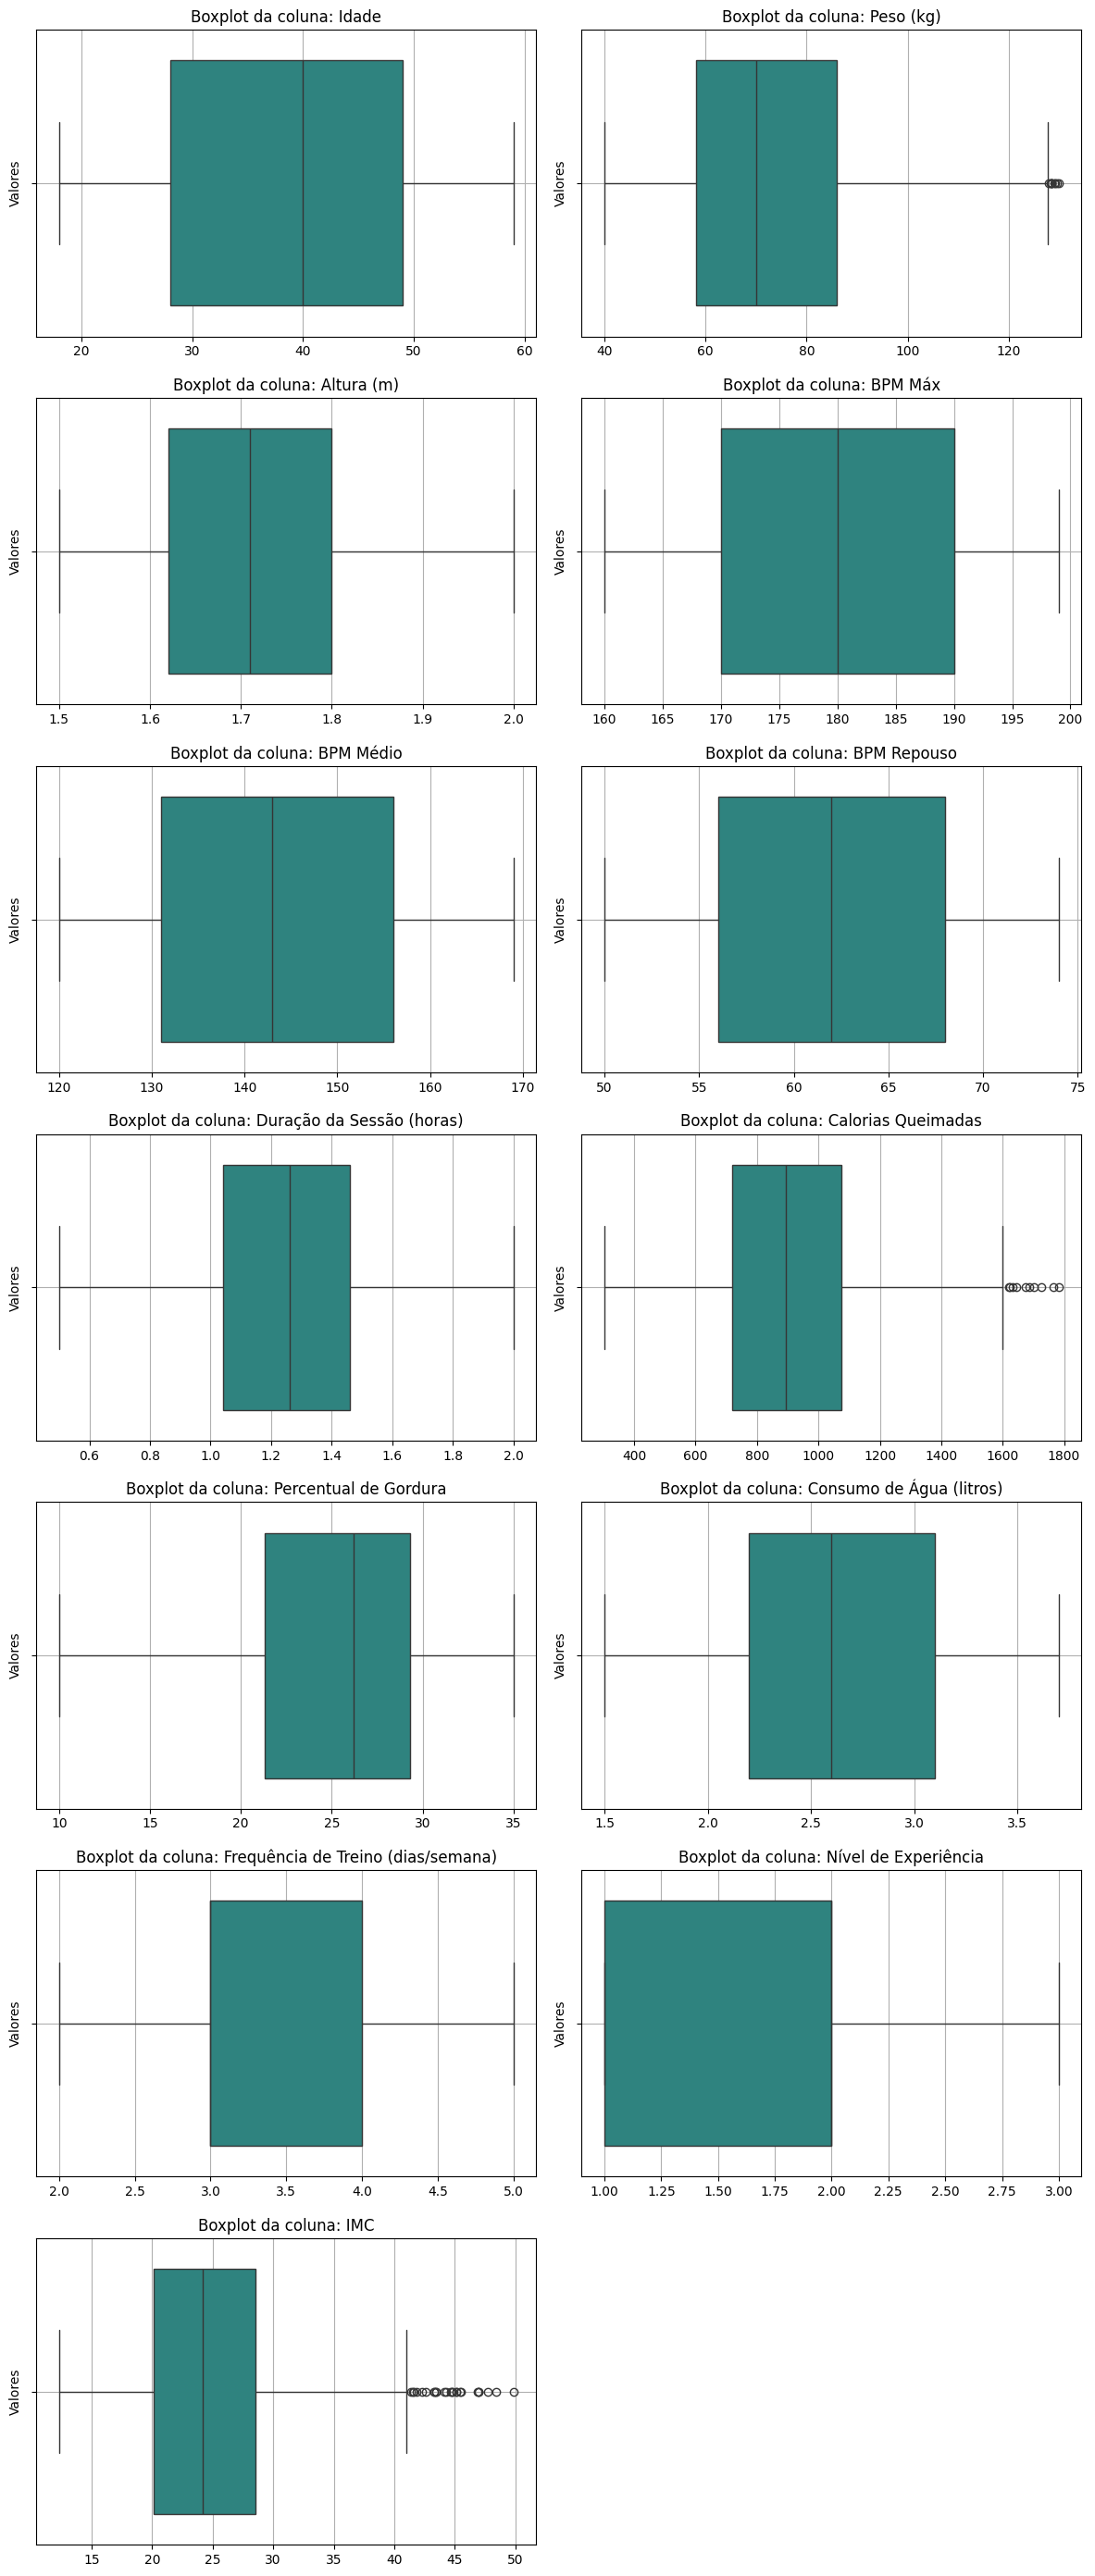

In [17]:
# Chamada da função para plotar os boxplots
boxplots(df_numerico, 2, (12,4))

Após exploração dos atributos por meio da visualização das distribuições em boxplots, verificou-se a presença de outliers em três deles: Peso (kg), Calorias Queimadas (atributo alvo) e IMC.
Como esses dados são necessários para a modelagem do problema, não serão descartados. Desse modo, será necessária a implementação de modelos mais robustos de forma que os outliers não influenciem significamente nos resultados.

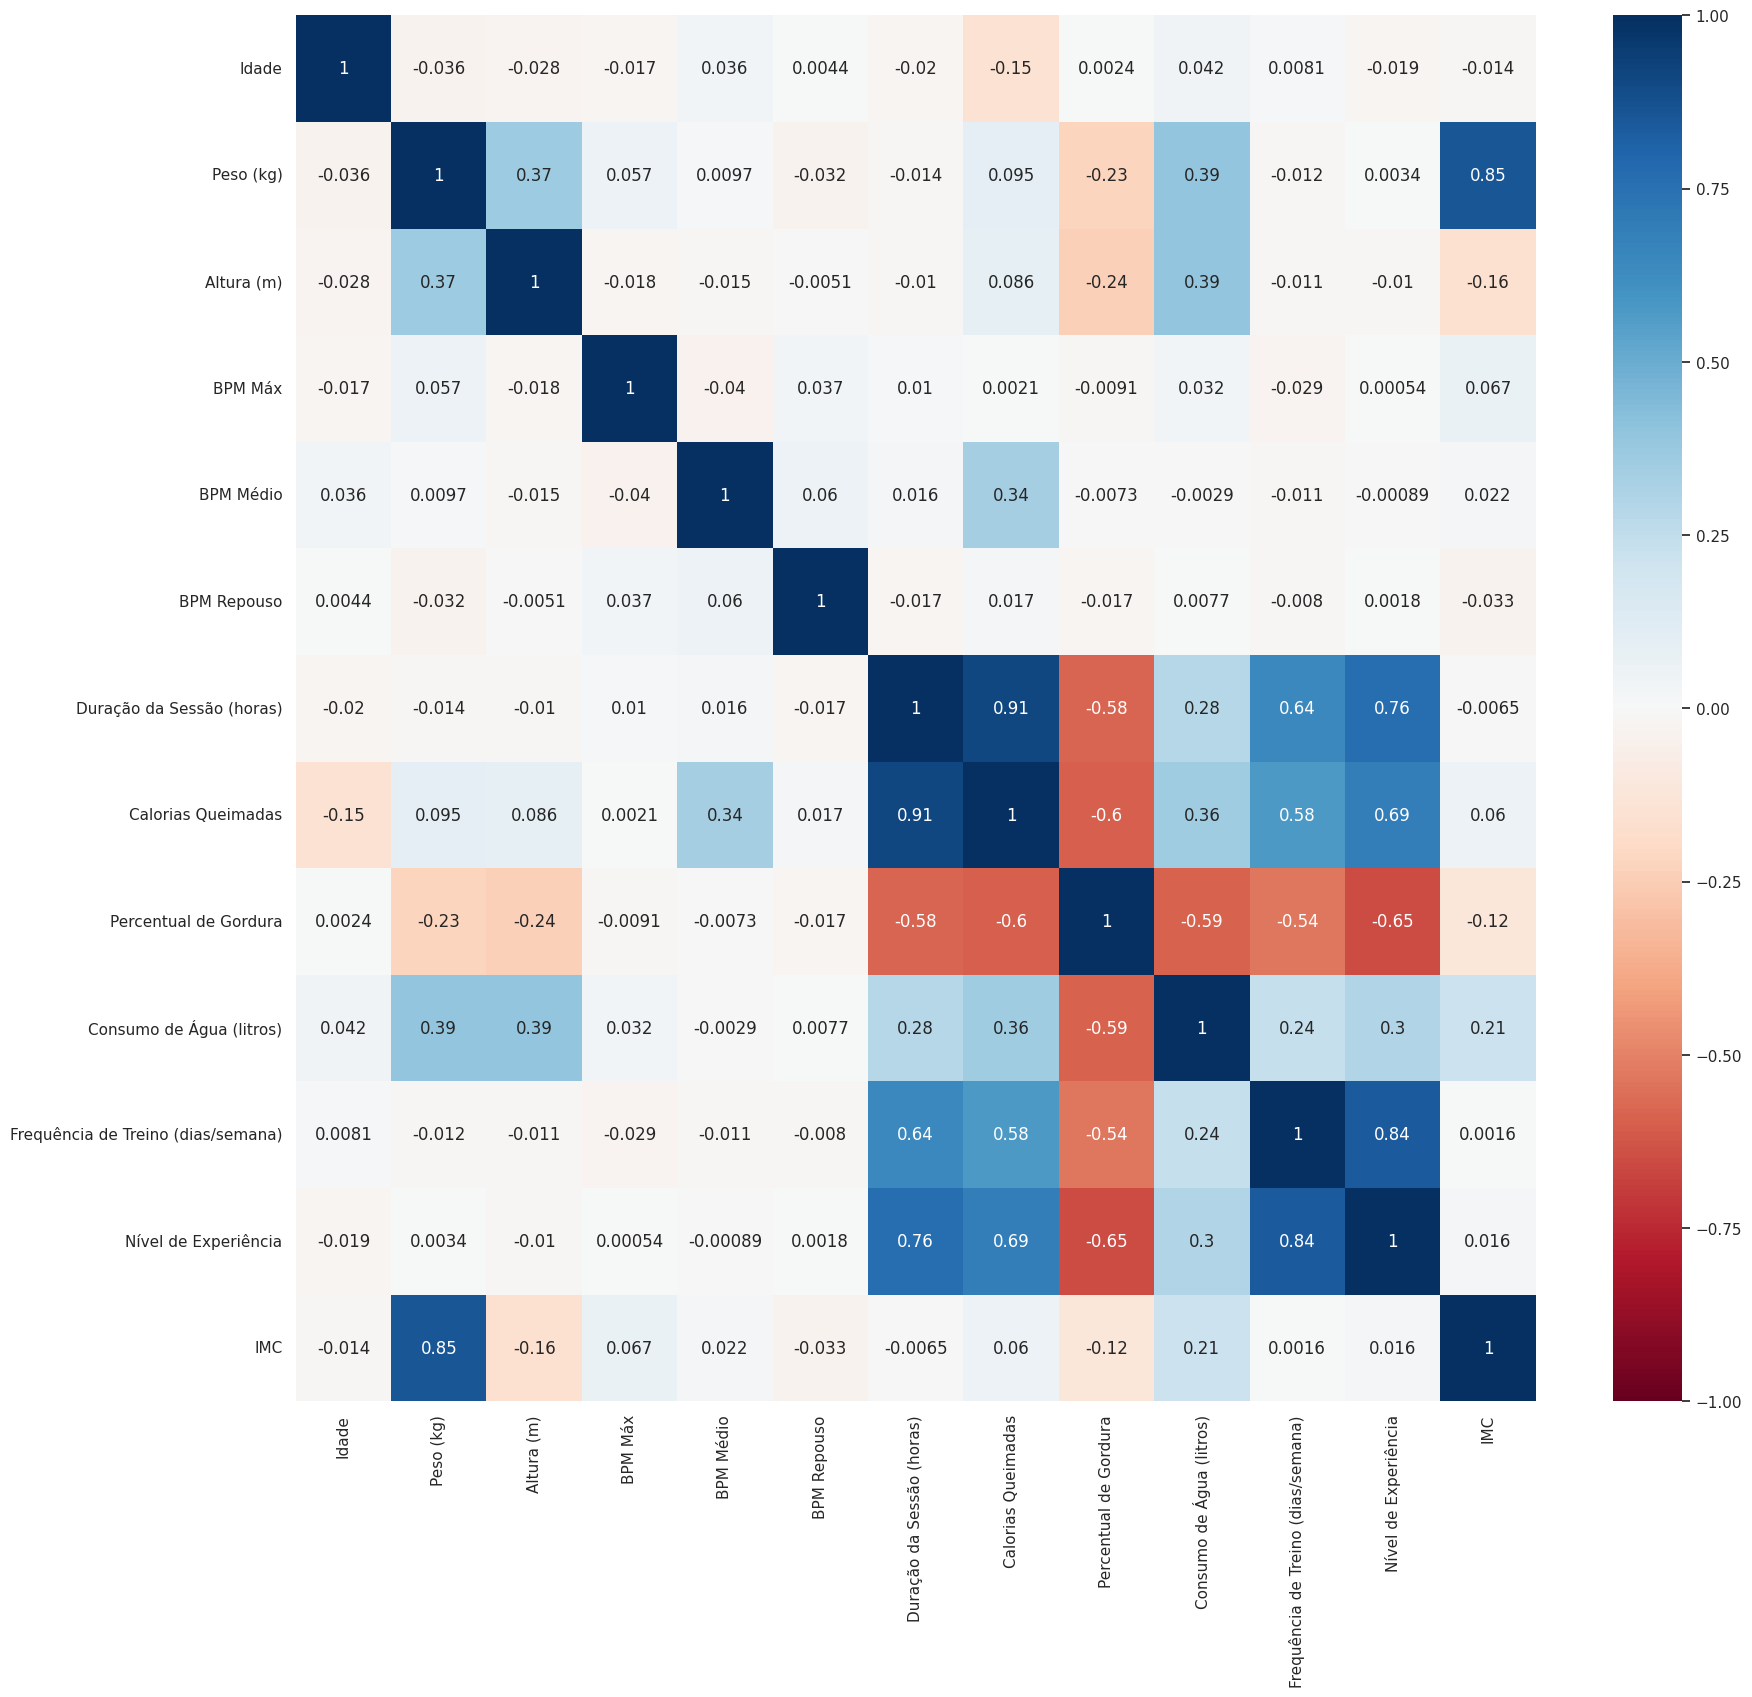

In [18]:
# Gerando a matriz de correlação de Pearson
plt.figure(figsize = (20,18))
sns.heatmap(df_numerico.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);

## Construção do Modelo de Machine Learning

### Separação dos dados e divisão dos conjuntos de treino e teste

Os dados são divididos em bases de treino e teste. Foi escolhida uma divisão da base de dados em 80% para treino e 20% para teste.
O atributo categórico "Gênero" foi considerado nesse processo de divisão. A mesma é realizada de forma que as classes "Male" e "Female" estejam distrubuídas uniformemente entre as bases de treino e teste, reduzindo o risco de viés causado por desequilíbrio entre as bases.

In [ ]:
# Divisão das matrizes
X = dataframe.drop(columns=['Calorias Queimadas'])  # Atributos de predição
y = dataframe['Calorias Queimadas']                 # Atributo alvo

# Garantir a presença do atributo "Gênero"
if 'Gênero' not in X.columns:
    raise ValueError("O atributo 'Gênero' deve estar presente no conjunto de dados.")

# Dividir em treino e teste com estratificação no atributo "Gênero"
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=X['Gênero']
                                                    )

# Verificar a distribuição do atributo "Gênero" em treino e teste
print("Distribuição em X_train:")
print(X_train['Gênero'].value_counts(normalize=True))

print("\nDistribuição em X_test:")
print(X_test['Gênero'].value_counts(normalize=True))

# Dividir em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

Distribuição em X_train:
Gênero
Male      0.525707
Female    0.474293
Name: proportion, dtype: float64

Distribuição em X_test:
Gênero
Male      0.523077
Female    0.476923
Name: proportion, dtype: float64


Após a divisão das bases de treino e teste, o conjunto de teste será aplicado em vários modelos de regressão. Nesse processo, foi escolhido o método da validação cruzada para o treinamento desses modelos. O número k-folds escolhido foi 10.

In [ ]:
# Lista de modelos de regressão
modelos = {
    'Regressão Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Árvore de Decisão': DecisionTreeRegressor(random_state=42),
    'KNN Regressor': KNeighborsRegressor(),
    'SVR': SVR()
}

# Escaladores a serem testados
escaladores = {
    'Dataset original': None,
    'Com Normalização': MinMaxScaler(),
    'Com Padronização': StandardScaler()
}

# Configuração da validação cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Scorers personalizados
scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R²': make_scorer(r2_score)
}

# Identificar colunas categóricas e numéricas
categorical_columns = ['Gênero', 'Tipo de Treino']
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]

# Configurar transformações para as colunas categóricas e numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),  # Manter colunas numéricas
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # One-hot nas categóricas
    ]
)

# Avaliar todos os modelos com validação cruzada
resultados_cv = []

# Avaliar todos os modelos com validação cruzada
resultados_cv = []

for esc_name, scaler in escaladores.items():
    for model_name, model in modelos.items():
        # Criar o pipeline
        steps = [('preprocessor', preprocessor)]  # Adicionar o preprocessor
        if scaler:  # Adicionar escalador se necessário
            steps.append(('scaler', scaler))
        steps.append(('model', model))
        pipeline = Pipeline(steps)

        # Avaliar cada métrica com validação cruzada
        for metric_name, scorer in scorers.items():
            scores = cross_val_score(
                pipeline, X_train, y_train, cv=kf, scoring=scorer
            )
            resultados_cv.append({
                'Escalador': esc_name,
                'Modelo': model_name,
                'Métrica': metric_name,
                'Média': -scores.mean() if metric_name in ['MAE', 'MSE'] else scores.mean(),
                'Desvio Padrão': scores.std()
            })

# Converter resultados em DataFrame
resultados_cv_df = pd.DataFrame(resultados_cv)

# Exibir os resultados ordenados por métrica e desempenho
for metric in ['MAE', 'MSE', 'R²']:
    print(f"\nResultados para {metric}:")
    print(resultados_cv_df[resultados_cv_df['Métrica'] == metric]
          .sort_values(by='Média', ascending=metric != 'R²'))


Resultados para MAE:
           Escalador             Modelo Métrica       Média  Desvio Padrão
69  Com Padronização  Gradient Boosting     MAE   15.928091       1.695839
15  Dataset original  Gradient Boosting     MAE   15.954652       1.725784
42  Com Normalização  Gradient Boosting     MAE   15.977833       1.709612
60  Com Padronização              Lasso     MAE   30.137975       3.004032
57  Com Padronização              Ridge     MAE   30.218862       2.998220
33  Com Normalização              Lasso     MAE   30.224439       2.805482
27  Com Normalização   Regressão Linear     MAE   30.241522       3.015517
54  Com Padronização   Regressão Linear     MAE   30.241522       3.015517
0   Dataset original   Regressão Linear     MAE   30.241522       3.015517
6   Dataset original              Lasso     MAE   30.316641       2.826359
3   Dataset original              Ridge     MAE   30.338933       2.874611
30  Com Normalização              Ridge     MAE   30.933037       2.807475
66 

### Aplicação do modelo na base de treino

In [ ]:
# Definir transformações para colunas numéricas e categóricas

atributos_num = ['Idade',
                    'Peso (kg)',
                    'Altura (m)',
                    'BPM Máx',
                    'BPM Médio',
                    'BPM Repouso',
                    'Duração da Sessão (horas)',
                    'Percentual de Gordura',
                    'Consumo de Água (litros)',
                    'Frequência de Treino (dias/semana)',
                    'Nível de Experiência',
                    'IMC'
                    ]

atributos_cat = ['Gênero', 'Tipo de Treino']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Combinar transformações com ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, atributos_num),
        ('cat', categorical_transformer, atributos_cat)
    ])

# Construir o pipeline completo

pipeline = Pipeline(steps=[ ('preprocessor', preprocessor),
                            ('feature_selection',
                             SelectKBest(score_func=f_regression, k=5)),
                            ('classifier',
                             RandomForestRegressor(n_estimators=200,
                                                   random_state=42)) ]
                    )

# Avaliar pipeline
scores = cross_val_score(pipeline, X_train, y_train,
                         cv=10, scoring='neg_mean_squared_error')

print(f'Mean cross-validation MSE: {-scores.mean():.2f}')

Mean cross-validation MSE: 6456.12


In [ ]:
# Definir parâmetros para grid search
param_grid = {
    'feature_selection__k': [5, 10, 15], # Seleção de top-K características
    'classifier': [RandomForestRegressor(random_state=42),
                   GradientBoostingRegressor(random_state=42)], # Changed 'ensemble' to 'classifier'
    'classifier__n_estimators': [100, 200, 300],   # Número de árvores  # Changed 'ensemble__' to 'classifier__'
    'classifier__max_depth': [3, 5, 10, 15, 25]  # Profundidade da árvore # Changed 'ensemble__' to 'classifier__'
}

In [ ]:
# Usar validação cruzada para encontrar o melhor conjunto de hiperparâmetros
grid_search = GridSearchCV(pipeline,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

ValueError: Invalid parameter 'classifier' for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Idade', 'Peso (kg)',
                                                   'Altura (m)', 'BPM Máx',
                                                   'BPM Médio', 'BPM Repouso',
                                                   'Duração da Sessão (horas)',
                                                   'Percentual de Gordura',
                                                   'Consumo de Água (litros)',
                                                   'Frequência de Treino '
                                                   '(dias/semana)',
                                                   'Nível de Experiência',
                                                   'IMC']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gênero',
                                                   'Tipo de Treino'])])),
                ('scaler', StandardScaler()), ('model', SVR())]). Valid parameters are: ['memory', 'steps', 'verbose'].

### Aplicação do modelo na base de teste

In [ ]:
# Avaliar desempenho no conjunto de teste
y_pred = grid_search.best_estimator_.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Resultados
print("Melhor configuração do modelo:", grid_search.best_params_)
print("MAE no conjunto de teste:", mae)
print("MSE no conjunto de teste:", mse)
print("R² no conjunto de teste:", r2)

Melhor configuração do modelo: {'classifier': GradientBoostingRegressor(random_state=42), 'classifier__max_depth': 3, 'classifier__n_estimators': 400, 'feature_selection__k': 10}
MAE no conjunto de teste: 12.02761082345446
MSE no conjunto de teste: 306.06800170173506
R² no conjunto de teste: 0.9963312207655922


## Considerações finais